## Contexto

Una entidad bancaria acaba de realizar una campaña de marketing, cuyo objetivo buscaba lograr que los clientes contactados depositaran sus ahorros a plazo fijo. Los resultados fueron peor de lo esperado.
Esta campaña se enfocó en un 10% de la cartera total de clientes del banco.

El banco nos provee la lista de los ~4.5K clientes ("clientes.csv") que fueron contactados durante esta última campaña y nos informa que por el momento NO nos proveerá de mas datos que estos.

Nuestra tarea consiste en ayudar al banco a cumplir sus objetivos.

## Objetivos

* Repetir una o más campañas en el transcurso de los siguientes 18 meses. 
* Maximizar la tasa de conversión de las mismas y entender los factores que influyen en esta tasa.

## Metadata

#### Datos clientes
1. age: edad del clietne
2. job: tipo de trabajo
3. marital: estado civil
4. education: nivel de educación
5. default: indica si el cliente registra algún default crediticio
5. balance: saldo en dólares de la caja de ahorro del cliente
6. housing: indica si el cliente posee un préstamo hipotecario
7. loan: indica si el cliente posee algún préstamo personal

#### Datos del último contacto de la campaña actual
9. contact: canal de contacto
10. day: día de último contacto
11. month: mes de último contacto
12. duration: duracion del último contacto
13. campaign: cantidad de contactos durante la campaña

#### Datos campaña previa
14. pdays: días transcurridos desde el último contacto por una campaña previa
15. previous: cantidad de contactos previous a esta campaña
16. poutcome: resultado de la campaña previa

#### Resultado campaña actual
17. y - Indica si el cliente realizó depósito a plazo fijo(binaria: 'yes','no')

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
#pip install grid (Libreria para explorar los datos de una forma mas comoda)

In [3]:
url = "https://drive.google.com/file/d/1cCFP52W3qz0aEbxowo7MpiKozAPlyqF7/view?usp=sharing"
path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
data = pd.read_csv(path, sep = ";")
data.head() #Estado del dataset


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [4]:
from qgrid import show_grid
show_grid(data)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Podemos ordenar los datos de forma ascedente y descendente, donde podemos observar posibles outliers en algunas variables. En dias transcurridos desde el ultimo contacto aparece '-1' posiblemente un codigo donde puede interpretarse como que no hubo contacto con el cliente previo.

In [5]:
#pip install funpymodeling
#Ver tipo de variables.

from funpymodeling import status,freq_tbl
status(data)

,variable,q_nan,p_nan,q_zeros,p_zeros,unique,type
0,age,0,0.0,0,0.000000,67,int64
1,job,0,0.0,0,0.000000,12,object
2,marital,0,0.0,0,0.000000,3,object
3,education,0,0.0,0,0.000000,4,object
4,default,0,0.0,0,0.000000,2,object
5,balance,0,0.0,357,0.078965,2353,int64
6,housing,0,0.0,0,0.000000,2,object
7,loan,0,0.0,0,0.000000,2,object
8,contact,0,0.0,0,0.000000,3,object
9,day,0,0.0,0,0.000000,31,int64


* No tenemos valores nulos.
* Tenemos 357 valores 0 en balance, lo que podria representa un porcentaje muy bajo con respecto al total solo el 0.07%, de personas que no tienen balance.
* En previous tambien tenemos valores con 0, donde posiblemente la respuesta es que no se los haya contactado previamente.
* No tenemos alta cardinalidad en variables categoricas, donde el maximo de valores unicos es 12 en 'jobs'.

# Analisis Univariado

### Variables Numericas

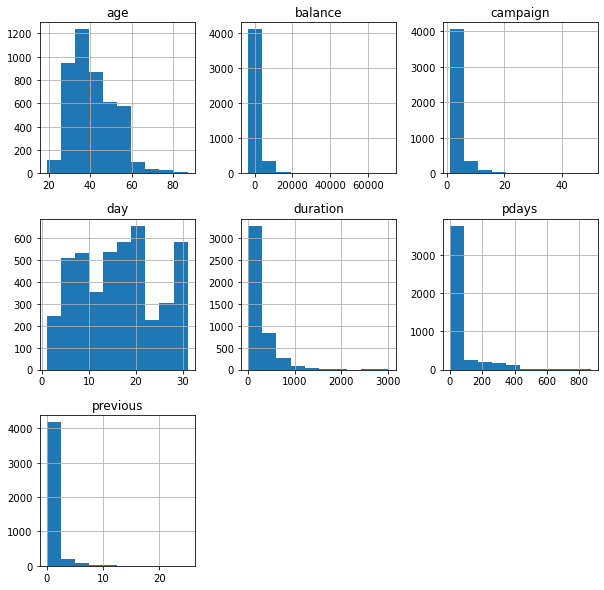

In [6]:
_ = data.hist(figsize= (10,10))

* La mayoria presenta una distribucion normal con asimetria hacia la derecha.
* Podemos observar una distribucion casi normal en edades, donde el rango medio se posiciona en 40

In [7]:
from funpymodeling import profiling_num
profiling_num(data)

,variable,mean,std_dev,variation_coef,p_0.01,p_0.05,p_0.25,p_0.5,p_0.75,p_0.95,p_0.99
0,age,41.170095,10.576211,0.256891,24.0,27.0,33.0,39.0,49.0,59.0,72.0
1,balance,1422.657819,3009.638142,2.115504,-671.4,-162.0,69.0,444.0,1480.0,6102.0,14194.6
2,day,15.915284,8.247667,0.518223,2.0,3.0,9.0,16.0,21.0,30.0,31.0
3,duration,263.961292,259.856633,0.984450,10.2,31.0,104.0,185.0,329.0,763.0,1259.0
4,campaign,2.793630,3.109807,1.113178,1.0,1.0,1.0,2.0,3.0,8.0,16.0
5,pdays,39.766645,100.121124,2.517716,-1.0,-1.0,-1.0,-1.0,-1.0,317.0,370.0
6,previous,0.542579,1.693562,3.121319,0.0,0.0,0.0,0.0,0.0,3.0,8.0


* Una buena herramienta es ver el coeficiente de variaciòn ya que mientras mas grande es este, mas chances que pueda contener outliers en 'Balance'. Donde el promedio es de $1422, pero posee una alta desviaciòn por lo que podemos inferir que esta altamente distribuido sobre todo el dataset. Aunque los promedios son altamente afectado por los outliers.
* Podemos ver que algunas personas tienen balance negativo en sus cuentas.
* Algo muy interesante es 'pdays' que es la cantidad de dias que pasaron desde el ultimo contacto teniendo una alta coeficiente de variaciòn, donde posiblemente si no aceptaron la propuesta se lo vuelve a llamar a una cierta cantidad de tiempo para volver a ofrecer la oferta.
* La duraciòn de las llamadas en segundos tambien presenta alta variaciòn, veremos como se comporta con respecto al deposito, analizando una posible correlaciòn que a mayor cantidad de tiempo, mayor aceptacion de la propuesta puede aplicar.
* Promedio de llamados durante la campaña son 3, una variable a investigar para saber si el equipo de venta esta ofreciendo de la manera correcta la oferta donde aceptaron la oferta, o posiblemente una directriz del equipo de marketing de solo realizar 2 llamados maximos.
* El 50% de la muestra como maximo recibio un llamado cada 2 semanas, aproximadamente.

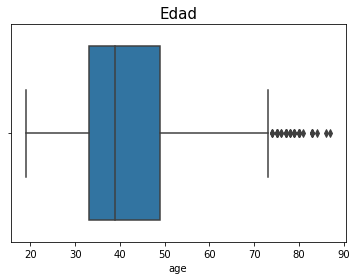

In [8]:
sns.boxplot(data['age'])
plt.title("Edad", fontsize = 15)
plt.show()

La mayor cantidad de clientes se encuentran en el rango de (30,50) aproximadamente.

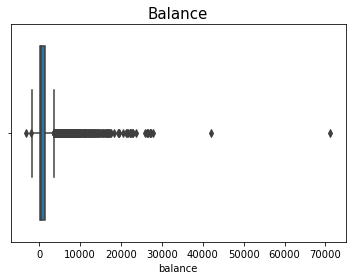

In [9]:
sns.boxplot(data['balance'])
plt.title("Balance" , fontsize = 15)
plt.show()

Se pueden observar personas que poseen un balance negativo en sus cuentas, donde le deben al banco y 2 valores outliers con respecto a los demas datos.

Las demas variables de la campaña anterior lo veremos mas detalladas de como se comporta con respecto a nuestro target 'y', si depositò o no.

### Variables Categòricas

**Variable a predecir 'y' (deposita/no deposita)**

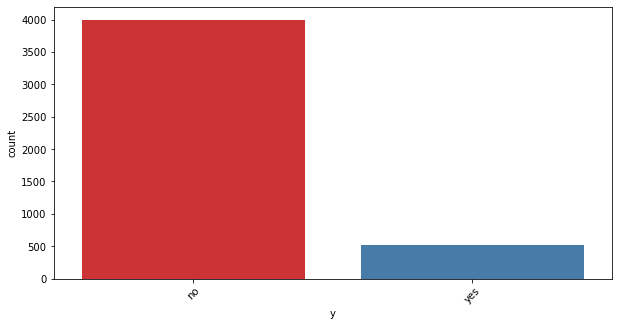

In [10]:
plt.figure(figsize=(10,5))
chart = sns.countplot(data['y'],palette = 'Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

In [11]:
data['y'].value_counts()

no     4000
yes     521
Name: y, dtype: int64

In [12]:
521/4000

0.13025

El dataset esta desbalanceado donde tenemos una proporcion 87/13 que podria afectar a nuestro modelos, por lo que tenemos que balancearlo para poder tener una modelacion con resultados mas orientados a la realidad.

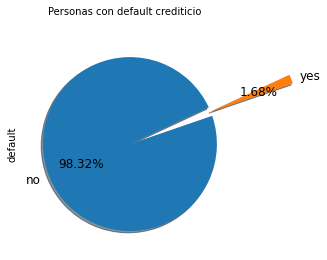

In [13]:
plt.suptitle('Personas con default crediticio', fontsize=10)
_ = data["default"].value_counts().plot.pie(explode=[0,1], autopct='%1.2f%%', shadow=True, fontsize=12, startangle=25)

Proporcion de los clientes que tienen default crediticio y poca habilidad de pago

In [14]:
#pip install pandas_profiling
from pandas_profiling import ProfileReport
ProfileReport(data, minimal=True)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Nos centraremos en las variables categoricas solamente para ver como se comportan para luego estudiarlas mas a detalle, con esta libreria es util para hacer una exploracion general donde nos da valores estadisticos de las variables categoricas mas unificado, solamente sirve para exploratorio y no operativo debido a que no se pueden realizar algun tipo de filtro alguno. 

* Job: Trabajos gerenciales y operarios (21.4 % 20.9% de frecuencia sobre el total) estan representados en nuestro dataset, casi el 50% de las personas.
* Marital : El 61,9% de los clientes se encuentra casado
* Education : La mitad tiene secundario completo y el 29,9 tiene niveles terciarios.
* Contact: Al 64% se lo contacto por telefono celular contra el 6.7% que fue por telefono de linea, donde posiblemente la gente mayor tuvo esta via de contacto.
* Month: La mayor cantidad de contacto se realizo en Mayo,Julio,Agosto.
* poutcome: No se tienen datos significantes de la penultima campaña.
* La mitad de los clientes tienen un credito hipotecario.
    

### Analisis Bivariado

In [15]:
# Dataset variables numericas
data_numerica = data.copy()

In [16]:
#Cambio las variables categoricas a binarias con (0,1)
for f in ['default', 'housing', 'loan', 'y']:
    data_numerica[f] = pd.Series(np.where(data_numerica[f].values == 'yes', 1, 0), data.index)

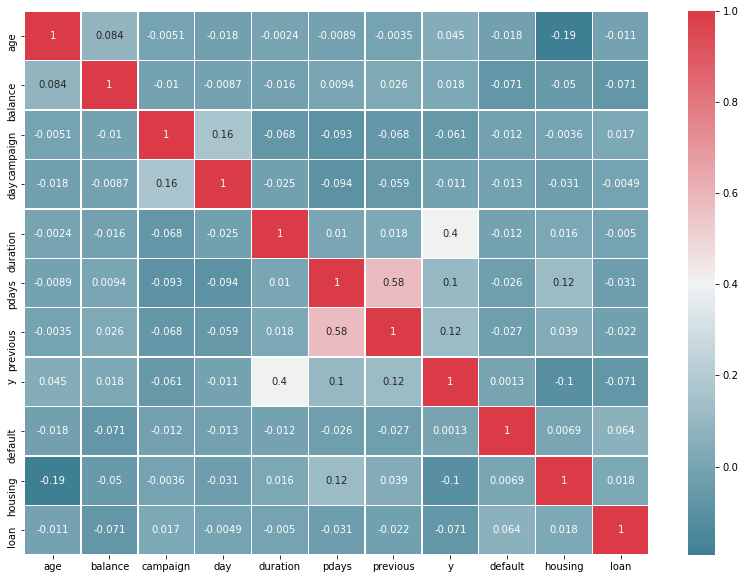

In [17]:
# Matriz de correlacion con variable deposito
var_n = ['age', 'balance', 'campaign', 'month', 'day', 'duration', 'pdays', 'previous']
var_n_dep = var_n + ['y'] + ['default'] + ['housing'] + ['loan'] 
plt.figure(figsize=(14,10))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_numerica[var_n_dep].corr(), cmap=cmap, annot=True, linewidths=.5);

Con respecto a la hipotesis sobre la duracion de llamada correlacionada con el deposito (basado en que a mientras mas segundos en telefono, mayor correlacion en la aceptacion de la propuesta):
   * ¿Si posee housing que pagar, influye en que pueda aceptar?


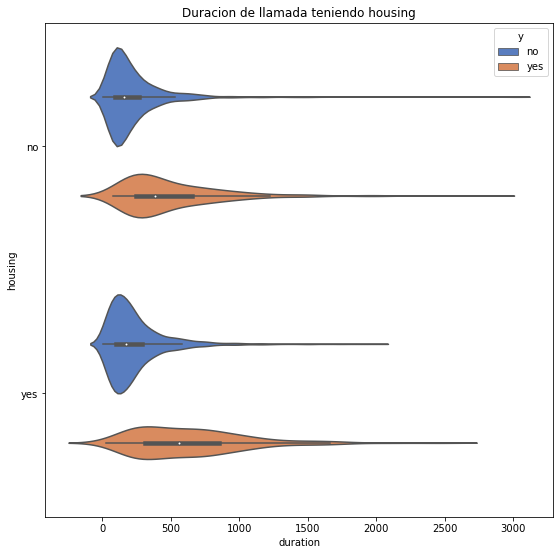

In [18]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(221)

dr_y = sns.violinplot(x="duration", y="housing", hue="y",
                    data=data, palette="muted", ax=ax1)
_ = dr_y.set_title('Duracion de llamada teniendo housing')

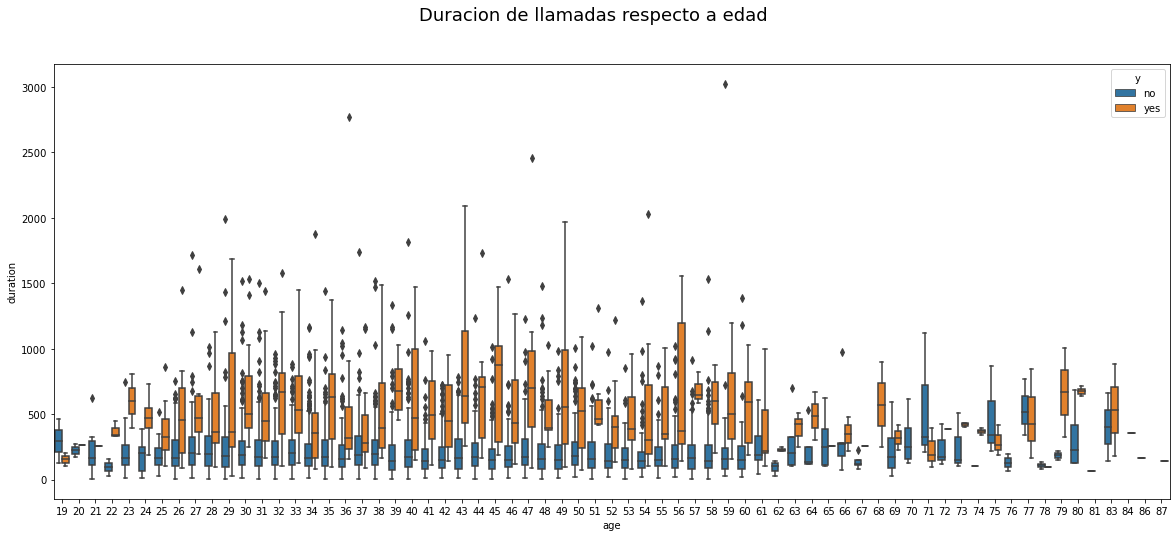

In [19]:
# Duracion respecto a edad
#################################
fig1 = plt.figure(figsize=(20,8))
fig1.suptitle('Duracion de llamadas respecto a edad', fontsize=18)
jd_y = sns.boxplot(x="age", y= "duration",hue= 'y',
                  data=data) 
plt.show()

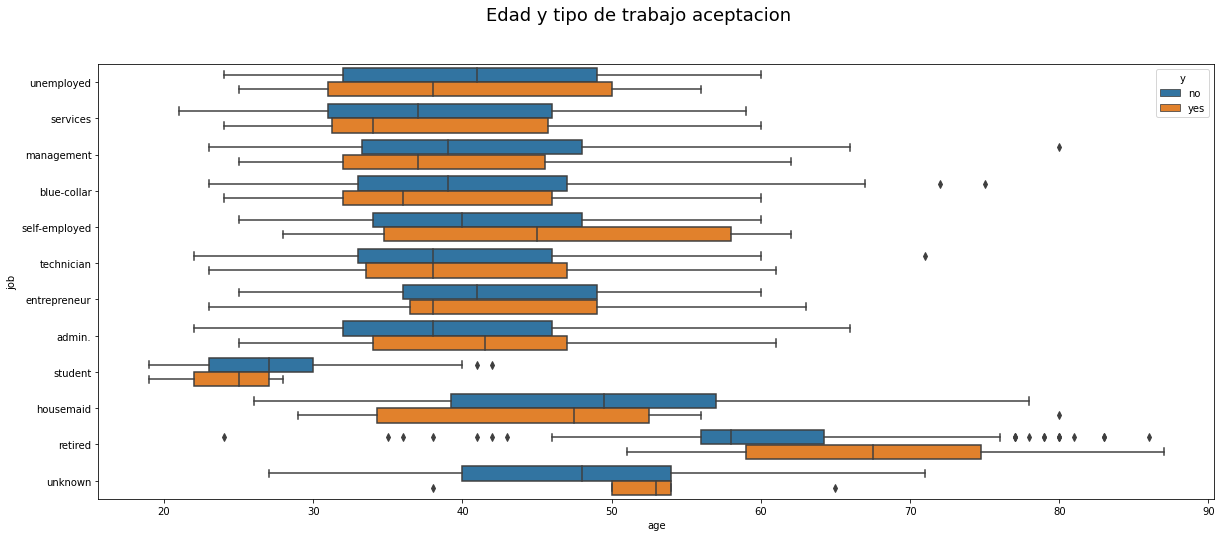

In [20]:
# Trabajo y edad respecto a oferta.
###################################
fig1 = plt.figure(figsize=(20,8))
fig1.suptitle('Edad y tipo de trabajo aceptacion', fontsize=18 )
jd_y = sns.boxplot(x="age", y= "job", hue="y",
                  data=data) 
plt.show()

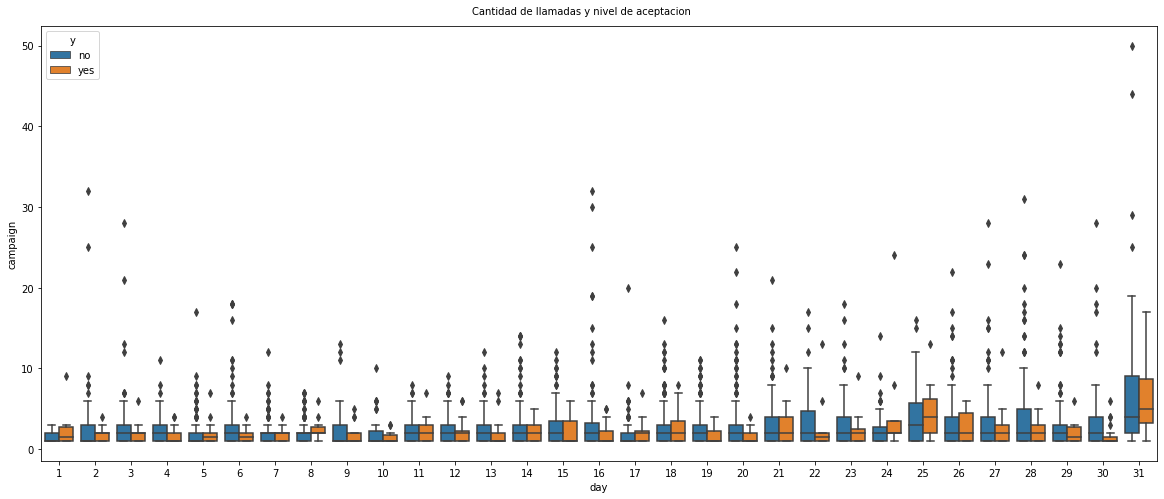

In [21]:
#Cantidad de llamadas con la aceptacion de propuesta.
####################################################
plt.figure(figsize=(20,8))
plt.style.use("default")
fig3 = sns.boxplot(data=data, x="day", y="campaign", hue = 'y')
#fig3.suptitle('Duracion de llamadas respecto a edad', fontsize=18, fontweight='bold')
_ = plt.figtext(.5,.9,'Cantidad de llamadas y nivel de aceptacion', fontsize=10, ha='center')

In [22]:
# Aceptacion con respecto a la media de duracion de llamado.#
#############################################################
data_numerica['menor_y'] = data_numerica['duration'].mean() < data_numerica['duration']
data_numerica['mayor_y'] = data_numerica['duration'].mean() > data_numerica['duration']
pd.crosstab(data_numerica.menor_y,data_numerica.y,
            rownames = ["Aceptacion"],
            colnames = ["Deposita no (0) / si (1)"]
            ).apply(lambda x: round(x/x.sum(),4) * 100, axis=1) #Funcion % eje columnas

Deposita no (0) / si (1),0,1
Aceptacion,,
False,95.51,4.49
True,74.23,25.77


In [23]:
data_numerica.shape

(4521, 19)

In [24]:
#Dropeamos los nuevos features creados en mi dataset numerico
data_numerica.drop(['menor_y', 'mayor_y'], axis='columns', inplace=True)

In [25]:
data_numerica.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,0,1787,0,0,cellular,19,oct,79,1,-1,0,unknown,0
1,33,services,married,secondary,0,4789,1,1,cellular,11,may,220,1,339,4,failure,0
2,35,management,single,tertiary,0,1350,1,0,cellular,16,apr,185,1,330,1,failure,0
3,30,management,married,tertiary,0,1476,1,1,unknown,3,jun,199,4,-1,0,unknown,0
4,59,blue-collar,married,secondary,0,0,1,0,unknown,5,may,226,1,-1,0,unknown,0


**Resumen**

* No hay mucha variacion con los que poseen housing, aunque la duracion de la llamada debido a su situacion puede haber derivado en otras consultas no relacionadas a la oferta.

* Vimos con respecto a las demas variables una pequeña correlacion de la edad con que depositaran, el fuerte se entre entre los rangos de (29,56) años respectivamente que aceptaron la propuesta. Y los retirados mayores a esta edad tambien tienen un porcentaje de aceptacion.

* Mas de 25 llamadas se puede observar que no aceptan las ofertas. La aceptacion se encuentra con menos de 25 mayoritariamente.
 
* Hay una leve tendencia alcista en aceptacion de la campaña mientras mas dia tiempo pasa desde el ultimo dia de contacto con la persona. Posiblemente por la insistencia en el corto tiempo, terminan por declinar la oferta. Es un area de oportunidad donde se puede ajustar los tiempos de llamados para evitar por la insistencia un 'no' de la propuesta. 

* El 25.77% de las personas que superaron la media de duracion de llamado (263 segundos/4.38 min) aceptaron la propuesta y solamente, un 4.49% acepto la propuesta en menos de ese tiempo. Teniendo un alto rechazo en los primeros minutos. Influyendo el tiempo pero no de una manera muy significativa. La duracion de la llamada aunque tenga correlacion con el deposito, no es causalidad del mismo.


No hay mucha relacion con las variables numericas respecto a nuestro target, vamos a investigar un poco mas con las variables categoricas.

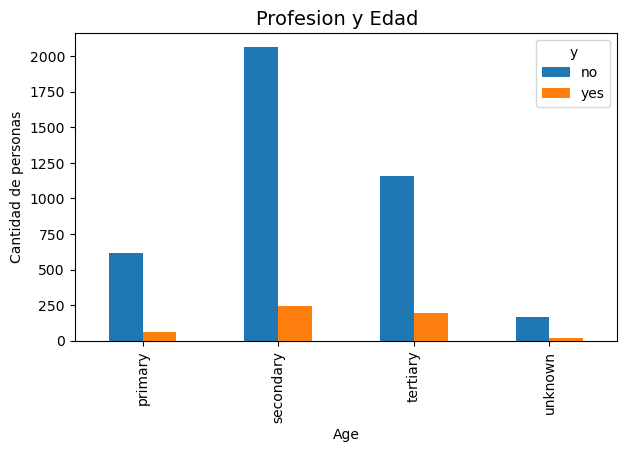

In [26]:
# Aceptacion por profesion y edad
#################################
plt.style.use("default")
ax = pd.crosstab(data.education,data.y).plot(kind="bar",figsize=(7,4),use_index=True)
plt.figtext(.5,.9,'Profesion y Edad', fontsize=14, ha='center')
plt.xlabel('Age')
plt.ylabel('Cantidad de personas')
plt.show()

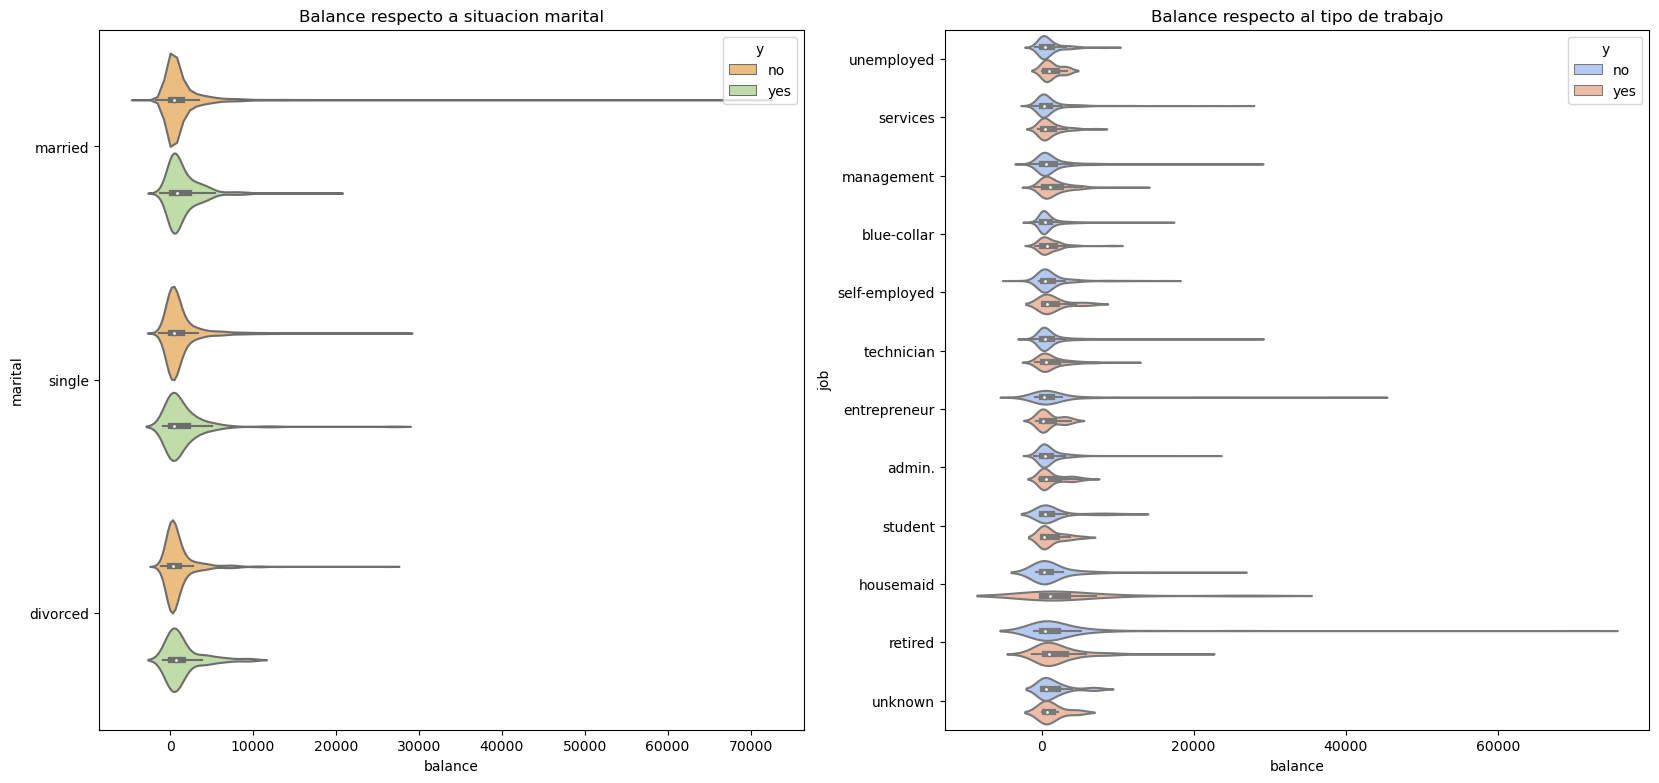

In [27]:
# Balance de cuenta respecto a situacion marital y trabajo
##########################################################
fig1 = plt.figure(figsize=(20,20))
ax3 = fig1.add_subplot(221)
ax4 = fig1.add_subplot(222)
bm_y = sns.violinplot(x="balance", y="marital", hue="y",
                    data=data, palette="Spectral", ax=ax3)
_ = bm_y.set_title('Balance respecto a situacion marital')
bj_y = sns.violinplot(x="balance", y="job", hue="y",
                    data=data, palette="coolwarm", ax=ax4)
_ = bj_y.set_title('Balance respecto al tipo de trabajo')

In [28]:
# Porcentaje de deposito respecto al total
pd.crosstab(data.job,data.y,
            rownames = ["Tipo de Trabajo"],
            colnames = ["Deposita"],
            normalize = True)

Deposita,no,yes
Tipo de Trabajo,,
admin.,0.092900,0.012829
blue-collar,0.193984,0.015262
entrepreneur,0.033842,0.003318
housemaid,0.021677,0.003097
management,0.185357,0.028976
retired,0.038929,0.011944
self-employed,0.036054,0.004424
services,0.083831,0.008405
student,0.014377,0.004203


* Gerentes , tecnicos y operadores son los que mas aceptaron las ofertas.
* El balance de las personas divorcios es inferior que las demas. 
* El balance de jubilados, emprendedores y gerentes son los que predominan. Aunque emprendedores son unos de los que menos aceptacion tienen.
* Personas con estudios secundarios principalmente y luego terciarios tuvieron mayor aceptacion.

Observando como afecta el balance por el estatus marital y la diferencia de fuente de entrada de dinero (salario) por cada profesion. Veremos como se comportan estas 2 variables juntas con los niveles de estudio donde previamente pudimos observar una relacion de baja aceptacion con respecto a los estudios de grados.

In [29]:
#Creamos una copia del dataset para no modificarlo
data_eda = data.copy()

In [30]:
# Funcion para condiciones de nueva variable
def categorizar(fila):
    marital = fila.marital
    education = fila.education
    if marital == 'divorced':
        if education == 'secondary':
            return 'divorced/secondary'
        if education == 'tertiary':
            return 'divorced/tertiary'
        elif education ==  'primary':
            return 'divorced/primary'

    elif marital == 'single':
        if education == 'secondary':
            return 'single/secondary'
        if education == 'tertiary':
            return 'single/tertiary'
        elif education == 'primary':
            return 'single/primary'

    elif marital == 'married':
        if education == 'secondary':
            return 'married/secondary'
        if education == 'tertiary':
            return 'married/tertiary'
        elif education == 'primary':
            return 'married/primary'    
    
data_eda["EducationandStatus"] = data_eda.apply(categorizar, axis=1)

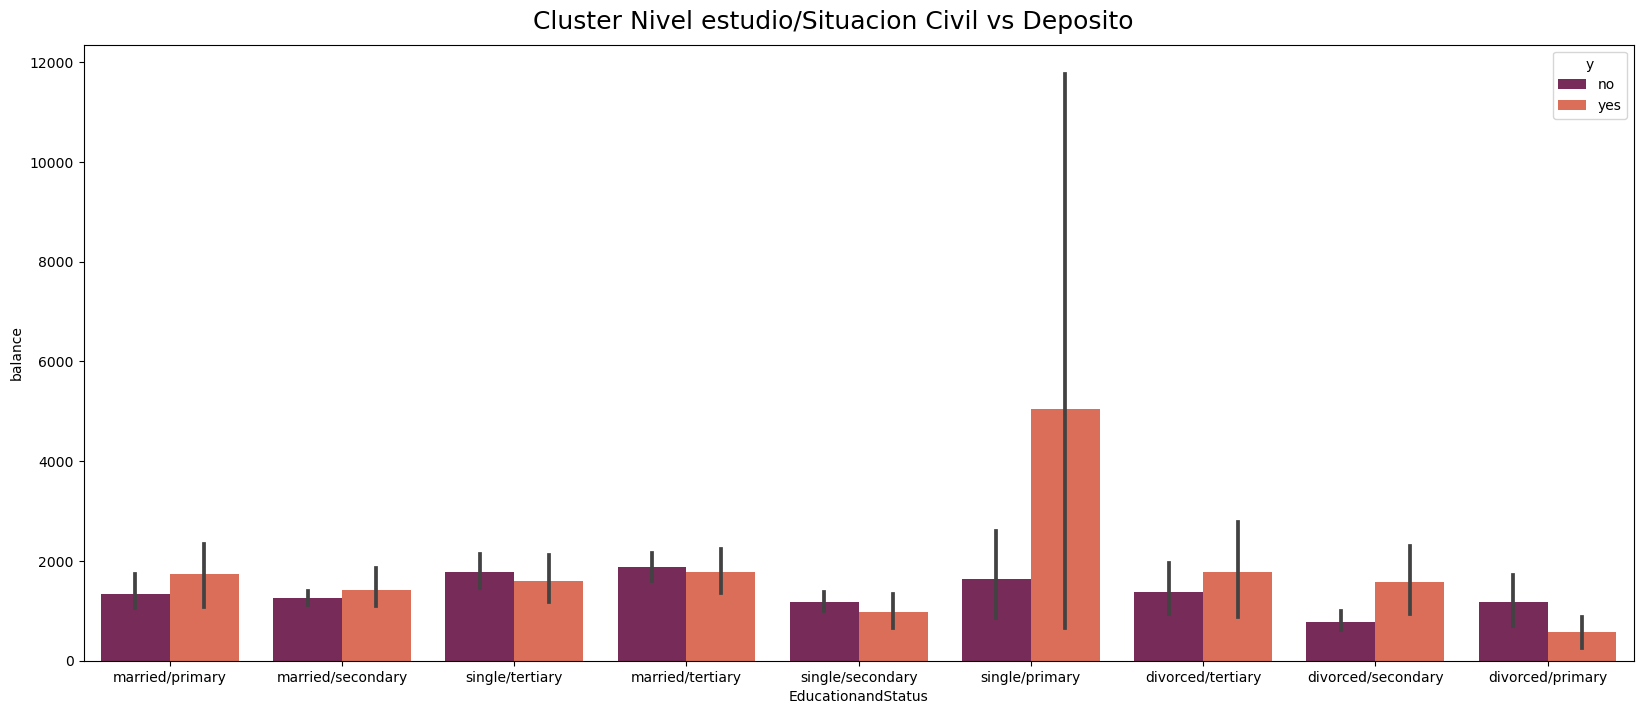

In [31]:
# Grafica por estudios y situacion marital.
fig = plt.figure(figsize=(20,8))
ax = sns.barplot(data=data_eda,y="balance", x="EducationandStatus", hue='y',
            palette="rocket")
_ = plt.figtext(.5,.9,'Cluster Nivel estudio/Situacion Civil vs Deposito', fontsize=18, ha='center')

In [32]:
# Aceptacion por educacion y estado civil (cluster)
pd.crosstab(data.y, data_eda.EducationandStatus, normalize = True, rownames = ['Aceptacion']).T

Aceptacion,no,yes
EducationandStatus,,
divorced/primary,0.014998,0.003230
divorced/secondary,0.053761,0.008537
divorced/tertiary,0.030457,0.005307
married/primary,0.111906,0.009460
married/secondary,0.299954,0.029303
married/tertiary,0.145824,0.021920
single/primary,0.014767,0.002077
single/secondary,0.121827,0.018689
single/tertiary,0.090678,0.017305


 * **Los solteros con primaria y con un balance superior a 4000 fueron los que mas aceptaron la oferta con respecto a los demas, hay una diferencia muy clara en base a este cluster por lo que es interesante tenerlo en cuenta a este target para proximas campañas personalizadas. En el siguiente escalon se encuentran las personas con terciario/divorciados.**
 * Casados a mayor grados de estudio mayor aceptacion
 * Solteros con primara solamente no hubo una aceptacion significativa
 * Divorciados con resultados bastante similares en cada caso.
 * Se puede observar que la aceptacion de casados con secundaria, fue mayor que la de el mismo grupo pero solo con primaria. Con estudios terciarios tambien hay un porcentaje de aceptacion superior en la mayoria de los grupos.

### Preparacion de datos para Modelos ML

Retiraremos outliers con balances mayores a 30,000 donde posterior a ese umbral no tuvo ninguna aceptacion, y para que no interfiera estos datos en nuestro modelos.

In [33]:
data_pro = data_numerica.copy() # Copia para cuidar el dataset original
data_pro = data_pro[data_pro['balance'] < 30000] # Son solamente 2 outliers

In [34]:
#Ver si hay datos duplicados
data_pro.duplicated().sum()

0

In [35]:
data_pro['pdays'] = data_pro["pdays"].replace(-1,0) #No contactados cambio a 0

La variable 'duration' es desconocida al momento de realizar la nueva prediccion, por lo que no podriamos usar esta variable de nuestro modelo en la campaña anterior. Nuestra intencion es predecir los clientes potenciales para la siguiente campaña.

In [36]:
#dropeamos la variable que no influiria en nuestra nuevas predicciones.
data_pro.drop(['duration'], axis='columns', inplace=True)

In [37]:
show_grid(data_pro)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [38]:
#GET DUMMIES con las otras variables
data_final = pd.get_dummies(data_pro, drop_first = True)
data_final.shape

(4519, 42)

In [39]:
#Dividimos los datos en train y test
from sklearn.model_selection import train_test_split

X = data_final.drop(['y'], axis=1)
y = data_final['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 42)
print("Train train size: ", X_train.shape)
print("Test test size: ", X_test.shape)

Train train size:  (3163, 41)
Test test size:  (1356, 41)


In [40]:
y_train.value_counts()

0    2800
1     363
Name: y, dtype: int64

In [41]:
#Standarizamos los datos
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

### Metrica para validacion de modelos. 

Se usara **Curva ROC** ya que al ser un dataset desbalanceado poca veracidad en casos reales podria tener Accuracy debido a este problema debido a la alta influecia de los 'No' en nuestra variable respuesta. La curva ROC performa sobre el ratio de True Positive y False Negative midiendo la calidad de las predicciones, si ambos esta sobre la linea base de 0.50 tendremos el modelo hara una mejor distincion de cada caso, accuracy no nos garantiza eso.

### Modelos Benchmark

Crearemos un modelo tipo benchmark para tener como base de comparacion con respecto a los modelos que desarrollaremos. El mismo se hara con [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html)

In [42]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix,plot_confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.dummy import DummyClassifier

In [43]:
#Creamos un DummyClassifier para tener los datos.
dummy_s = DummyClassifier(strategy='stratified', random_state=42)
dummy_s.fit(X_train,y_train)
#Predicciones en test y train    
y_train_pred_dummy = dummy_s.predict(X_train)
y_test_pred_dummy = dummy_s.predict(X_test)

In [44]:
#dummy_s.score(X_ptrain, y_ptrain)
dummy_s.score(X_test, y_test)

0.7765486725663717

In [45]:
#Funcion con algunas metricas 
def clasification_metrics (y_test, y_pred, pos_label = 1):
    accuracy = accuracy_score(y_test,y_test_pred_dummy)
    f1 = f1_score(y_test,y_test_pred_dummy, pos_label = pos_label)
    precision = precision_score(y_test,y_test_pred_dummy, pos_label = pos_label)
    recall = recall_score(y_test,y_test_pred_dummy, pos_label = pos_label)
    return [accuracy, f1, precision, recall]

Accuracy para Dummy: 0.78
Precision para Dummy: 0.06
Recall para Dummy: 0.06
F1 para Dummy: 0.06


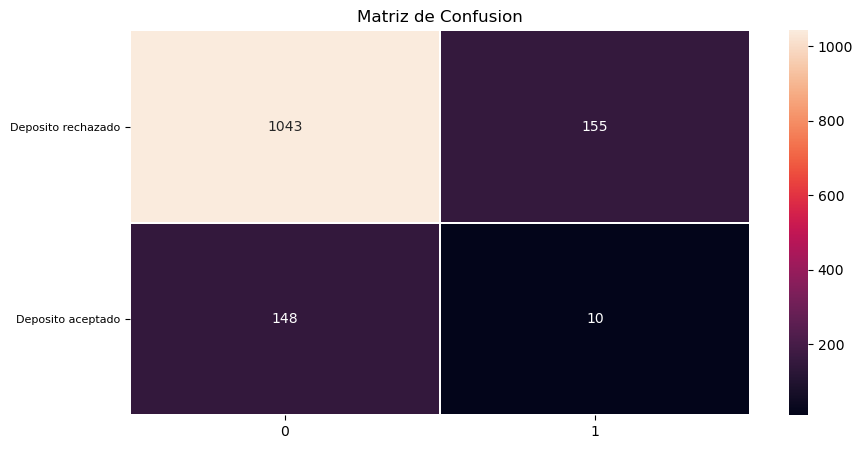

In [46]:
print("Accuracy para Dummy: %0.2f" % (clasification_metrics(y_test,y_test_pred_dummy)[0]))
print("Precision para Dummy: %0.2f" % (clasification_metrics(y_test,y_test_pred_dummy)[2]))
print("Recall para Dummy: %0.2f" % (clasification_metrics(y_test,y_test_pred_dummy)[3]))
print("F1 para Dummy: %0.2f" % (clasification_metrics(y_test,y_test_pred_dummy)[1]))
#Matriz de confusion
conf_matrix_dummy = confusion_matrix(y_test, y_test_pred_dummy)
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(conf_matrix_dummy, annot=True, fmt="d", linewidths=.5, ax=ax)
plt.title("Matriz de Confusion", fontsize=12)
ax.set_yticklabels(['Deposito rechazado', 'Deposito aceptado'], fontsize=8, rotation=360)
plt.show()

### Metrica curva ROC Dummys

In [47]:
y_score_dummy = dummy_s.predict_proba(X_test)
fpr_dummy, tpr_dummy, _ = roc_curve(y_test, y_score_dummy[:, 1])
roc_auc_dummy = auc(fpr_dummy, tpr_dummy)
roc_auc_dummy

0.4669544177003867

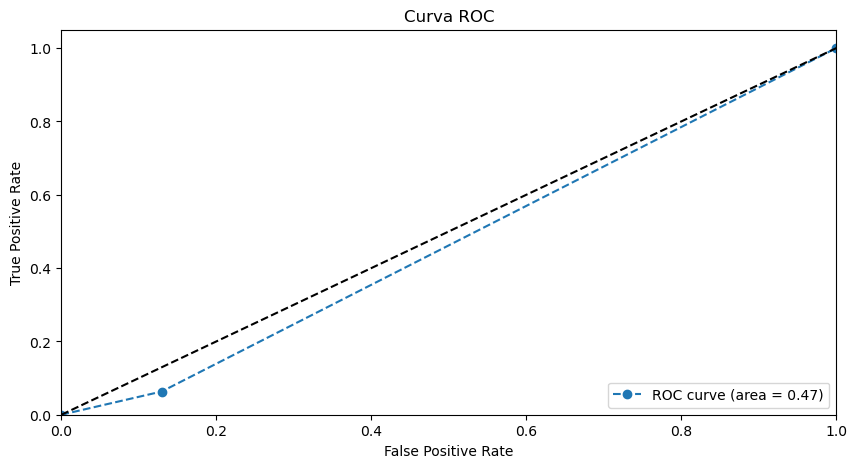

In [48]:
plt.figure(figsize=(10,5))
plt.plot(fpr_dummy, tpr_dummy,'o--', label='ROC curve (area = %0.2f)' % roc_auc_dummy)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Implementacion de modelos de ML con hyperparametros

In [49]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

In [50]:

# Logistic Regression
log_reg = LogisticRegression()
log_scores = cross_val_score(log_reg, X_train, y_train, cv=3)
log_reg_mean = log_scores.mean()

# SVC
svc_clf = SVC()
svc_scores = cross_val_score(svc_clf, X_train, y_train, cv=3)
svc_mean = svc_scores.mean()

# KNearestNeighbors
knn_clf = KNeighborsClassifier()
knn_scores = cross_val_score(knn_clf, X_train, y_train, cv=3)
knn_mean = knn_scores.mean()

# Decision Tree
tree_clf = DecisionTreeClassifier()
tree_scores = cross_val_score(tree_clf, X_train, y_train, cv=3)
tree_mean = tree_scores.mean()

# Gradient Boosting Classifier
grad_clf = GradientBoostingClassifier()
grad_scores = cross_val_score(grad_clf, X_train, y_train, cv=3)
grad_mean = grad_scores.mean()

# Random Forest Classifier
rand_clf = RandomForestClassifier(n_estimators=18)
rand_scores = cross_val_score(rand_clf, X_train, y_train, cv=3)
rand_mean = rand_scores.mean()

In [51]:
# Create a Dataframe with the results.
d = {'Clasificadores': ['Logistic Reg.', 'SVC', 'KNN', 'Dec Tree', 'Grad B CLF', 'Rand FC'], 
    'Crossval Media Scores': [log_reg_mean, svc_mean, knn_mean, tree_mean, grad_mean, rand_mean]}

result_df = pd.DataFrame(data=d)

In [52]:
result_df

,Clasificadores,Crossval Media Scores
0,Logistic Reg.,0.888712
1,SVC,0.883339
2,KNN,0.882391
3,Dec Tree,0.818208
4,Grad B CLF,0.884920
5,Rand FC,0.886500


Investigaremos mas a fondo con Regresion Logistica y Gradient Boost debido a que fueron los modelos que dieron mejores resultados.

In [53]:
# Defino pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import RepeatedStratifiedKFold
model = log_reg
# Evaluo pipeline y aplico Stratified y Cross debido a que es un dataset desbalanceado.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
rand_mean = scores.mean()
rand_mean
print('Mean ROC AUC en Train Regresion Logistica: %.3f' % rand_mean)

Mean ROC AUC en Train Regresion Logistica: 0.710


In [54]:
# Defino pipeline
model = grad_clf
# Evaluo pipeline y aplico Stratified y Cross debido a que es un dataset desbalanceado.
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
scores = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
grad_clf_mean = scores.mean()
grad_clf_mean
print('Mean ROC AUC en Train Gradient Boost: %.3f' % rand_mean)

Mean ROC AUC en Train Gradient Boost: 0.710


Es importante que las metricas de error tenga cross validation, porque nos daria una metrica mas "parecida" a como seria su performance con datos nuevos en produccion. 

In [55]:
#Entreno Regresion Logistica
log_reg.fit(X_train, y_train)
#Predicciones en test y train    
y_train_pred_lr = log_reg.predict(X_train)
y_test_pred_lr = log_reg.predict(X_test)

In [56]:
#Entreno con Gradient Boost
grad_clf.fit(X_train, y_train)
#Predicciones en test y train    
y_train_pred_grad_clf = grad_clf.predict(X_train)
y_test_pred_grad_clf = grad_clf.predict(X_test)

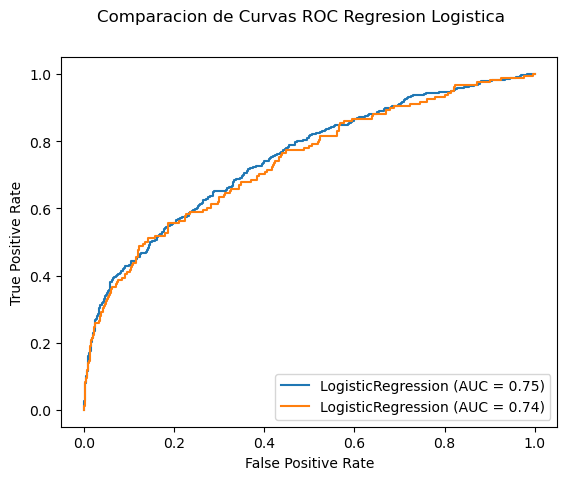

In [57]:
# Grafica de curva ROC de Regresion Logistica
from sklearn.metrics import plot_roc_curve
tr_disp = plot_roc_curve(log_reg, X_train, y_train)
ts_disp = plot_roc_curve(log_reg, X_test, y_test, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("Comparacion de Curvas ROC Regresion Logistica")
plt.show()

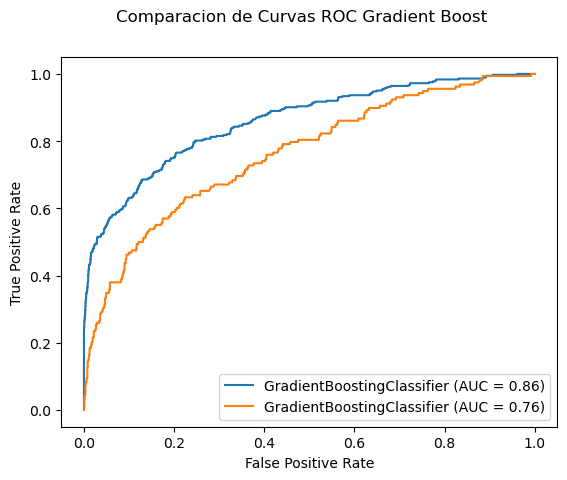

In [58]:
# Grafica de curva ROC de Gradiente Boost
tr_disp = plot_roc_curve(grad_clf, X_train, y_train)
ts_disp = plot_roc_curve(grad_clf, X_test, y_test, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("Comparacion de Curvas ROC Gradient Boost")
plt.show()

El modelo de Regresion Logistica a pesar de que tiene una metrica mas baja,es mas estable ya que la curva azul (testing) es muy similar a la curva de train.

### Metrica curva ROC Regresion Logistica

In [59]:
y_score = log_reg.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score[:, 1])
roc_auc_lg = auc(fpr, tpr)
roc_auc_lg

0.7385621605629635

### Metrica curva ROC Gradient Boost

In [60]:
y_score_grad_clf = grad_clf.predict_proba(X_test)
fpr_grad_clf, tpr_grad_clf, _ = roc_curve(y_test, y_score_grad_clf[:, 1])
roc_grad_clf = auc(fpr_grad_clf, tpr_grad_clf)
roc_grad_clf

0.7607193423638554

In [61]:
# Score respecto a train y test
log_reg.score(X_train, y_train)
log_reg.score(X_test, y_test)

0.8923303834808259

In [62]:
grad_clf.score(X_train, y_train)

0.9181157129307619

El resultado de la curva ROC nos demuestra que el modelo tiene una capacidad de 0.73 de probabilidad poder distinguir de clientes que depositen y los que no tienen intenciones de depositar.

<Figure size 1000x800 with 0 Axes>

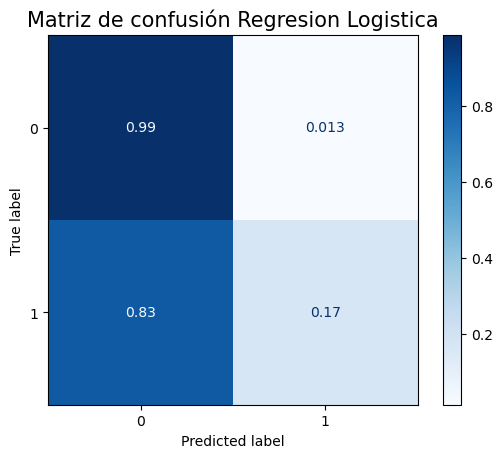

In [63]:
plt.figure(figsize=(10,8))
plot_confusion_matrix(log_reg,X_test, y_test,cmap=plt.cm.Blues,normalize='true')
plt.title("Matriz de confusión Regresion Logistica",size = 15)
plt.show()

In [64]:
grad_clf.score(X_test, y_test)

0.8938053097345132

### GridSearch para Regresion Logistica

In [65]:
clf = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],
               'C':[0.001,.009,0.01,.09,1.0,5,10,25,50,100],
               'solver':['newton-cg', 'lbfgs', 'liblinear']}
scoring = ['roc_auc']
log_reg_h = GridSearchCV(clf, param_grid=grid_values, cv=5,scoring = scoring ,refit='roc_auc')
log_reg_h.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1.0, 5, 10, 25, 50,
                               100],
                         'penalty': ['l1', 'l2'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear']},
             refit='roc_auc', scoring=['roc_auc'])

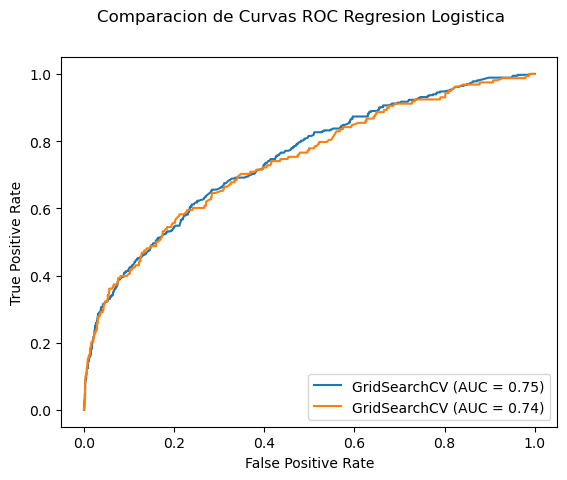

In [66]:
tr_disp = plot_roc_curve(log_reg_h, X_train, y_train)
ts_disp = plot_roc_curve(log_reg_h, X_test, y_test, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("Comparacion de Curvas ROC Regresion Logistica")
plt.show()

### GridSearch para Gradient Boost

In [67]:
gbc = GradientBoostingClassifier()
grid_values = {'subsample':[0.6,0.7,0.75,0.8,0.85,0.9]}
grab_hyp = GridSearchCV(estimator = gbc, param_grid = grid_values, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
grab_hyp.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), iid=False, n_jobs=4,
             param_grid={'subsample': [0.6, 0.7, 0.75, 0.8, 0.85, 0.9]},
             scoring='roc_auc')

In [68]:
# Mejores parametros
grab_hyp.best_estimator_

GradientBoostingClassifier(subsample=0.8)

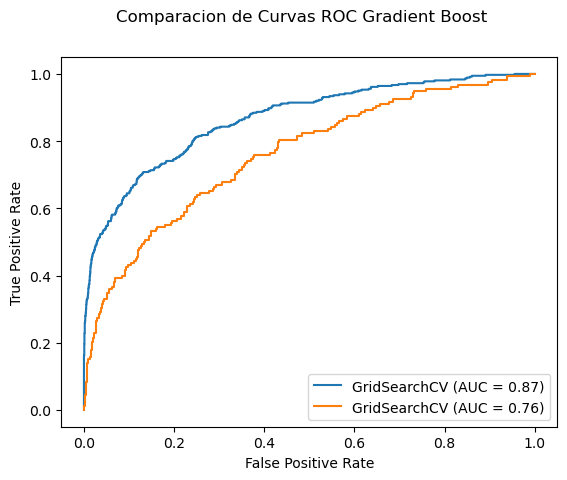

In [69]:
# Grafica de curva ROC de Gradiente Boost
tr_disp = plot_roc_curve(grab_hyp, X_train, y_train)
ts_disp = plot_roc_curve(grab_hyp, X_test, y_test, ax=tr_disp.ax_)
ts_disp.figure_.suptitle("Comparacion de Curvas ROC Gradient Boost")
plt.show()

Con tuneo de hyperparametros no hubo una diferencia significativa en Regresion Logistica, como tampoco la hubo en Gradient Boost, aunque esta ultima hace overfitting se seleccionara la Regresion Logistica.

**La regresion logistica nos da un AUC score de 0.74, lo que nos representa un 0.74 de probabilidad de que nuestro modelo pueda discernir de forma correcta de los posibles clientes que depositaran y de los que no.**

<Figure size 1000x800 with 0 Axes>

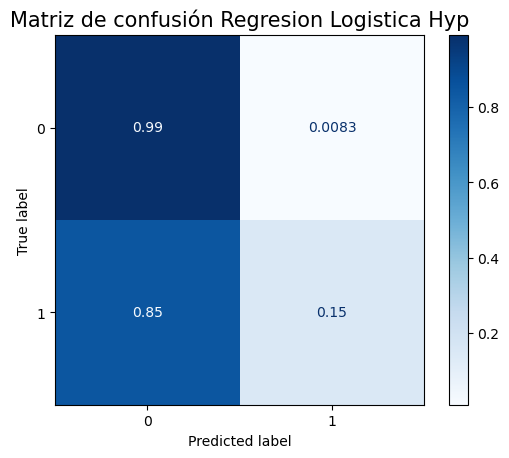

In [70]:
plt.figure(figsize=(10,8))
plot_confusion_matrix(log_reg_h,X_test, y_test,cmap=plt.cm.Blues,normalize='true')
plt.title("Matriz de confusión Regresion Logistica Hyp",size = 15)
plt.show()

### Threshold interactivo

Punto de corte por defecto es de 0.5 generalmente este ratio lo define el negocio.Esto va a depender de nuestro problema, si queremos favorecer una metrica u otra.

In [71]:
y_test_pred_hyp = log_reg_h.predict_proba(X_test)

In [72]:
#pip install ipywidgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.metrics import precision_recall_fscore_support


@interact(punto_corte=(0, 1, 0.01), model=['regresion logistica'])

def f2(model, punto_corte=0.5):
    if(model=='regresion logistica'):
        sel_model=y_test_pred_hyp
    else:
        pass

    y_pred_2=np.where(sel_model>punto_corte, 1, 0)
    conf_mat=pd.crosstab(y_test, y_pred_2[:,1], rownames=['Actual'], colnames=['Predicted'])
    sns.heatmap(conf_mat, annot=True, fmt='g')


    res = precision_recall_fscore_support(y_test, y_pred_2[:,1], average='binary')

    print("\nPrecision = %0.2f, recall = %0.2f, F1 = %0.2f, accuracy = %0.2f\n" % (res[0], res[1], res[2], accuracy_score(y_test, y_pred_2[:,1])))

interactive(children=(Dropdown(description='model', options=('regresion logistica',), value='regresion logisti…

* Clientes que contactamos porque aceptarian pero en realidad no aceptan (FP)
* Clientes que NO contactamos debido al modelo, pero si hubieran aceptado (FN).
* Clientes que contactamos por que el modelo dijo que si aceptarian y efectivamente lo hacen (TP)
* Clientes que NO contactamos porque el modelo predijo que aceptarian y si lo hacen.

**Si quiero disminuir los False Positives tengo que aumentar mi Threshold**

**Si quiero aumentar mis True Positives disminuyo mi threshold**

### Precision

¿Cuantos de las personas que vamos a llamar estaran interesados?. Segun nuestro modelo con punto de corte default (0.5) lo hara con un **71%**.

### Recall

¿Cuantos de los interesados logramos identificar del total que si lo hicieron? Segun nuestros modelo se lograra identificar al **15%** de los interesados.

### Feature importance

In [73]:
data_features = data.copy()
data_features

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [74]:
data_features['job'] = data_features['job'].astype('category').cat.codes
data_features['marital'] = data_features['marital'].astype('category').cat.codes
data_features['education'] = data_features['education'].astype('category').cat.codes
data_features['contact'] = data_features['contact'].astype('category').cat.codes
data_features['poutcome'] = data_features['poutcome'].astype('category').cat.codes
data_features['month'] = data_features['month'].astype('category').cat.codes
data_features['default'] = data_features['default'].astype('category').cat.codes
data_features['loan'] = data_features['loan'].astype('category').cat.codes
data_features['housing'] = data_features['housing'].astype('category').cat.codes

In [75]:
#Arbol de features importance
arbol_features = DecisionTreeClassifier(class_weight='balanced',min_weight_fraction_leaf = 0.01, random_state=42)
#Drop X , y
X_features = data_features.drop(['y'], axis=1)
y_features = data_features['y']
#Divido
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(X_features, y_features, test_size=0.30, random_state = 42)
#Entreno
arbol_features = arbol_features.fit(X_train_f, y_train_f)

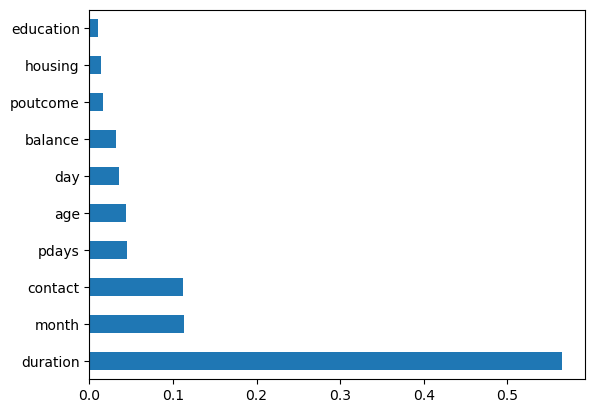

In [76]:
(pd.Series(arbol_features.feature_importances_, index=X_train_f.columns)
   .nlargest(10)
   .plot(kind='barh'))

* Duracion de la llamada

* Month

* Tipo de contacto

Son las variables con mayor importancia en la cual los modelos prestan atención para realizar la clasificación de los modelos.


### Recomendaciones

* Las campañas de marketing tienen un presupuesto destino para esta por lo que no se puede llamar a todos por estos recursos limitados. Se recomienda basado en el presupuesto y costos operativos modificar el punto de corte para evitar los llamados que no se convertiran en clientes, ya que eso repercutiria en el KPI de baja productividad y presupuesto sin retribucion de la oferta.


* La temporada es uno de los factores de clasificacion mas importate de nuestro modelo en el cual se recomienda tener diferentes puntos de cortes por estacionalidad, la cantidad de depositos disminuye en temporadas bajas (Diciembre,Septiembre) por lo que seria recomendable enfocarse en estas temporadas en los True Positives y disminuir los Falsos Negativos que me repercutiria en dinero gastado sin conversion de los clientes, en temporada baja de depositos.


* En la duracion de cada llamada pudimos que no habia un nivel de aceptacion significativo despues de superar la media de tiempo de los datos, es un area de mejora para capacitacion sobre ventas para el equipo de call center, evitando llamadas largas que no posiblemente no eran relacionadas a la oferta en si.


* Gracias a realizar ingenieria de variables pudimos observar un cluster de aceptacion diferenciador con respecto a los demas que es el de [Soltero/Balance (u$s +4000)] donde nos demuestra una buena estrategia sectorizar las poblaciones ofreciendo propuestas personalizadas con respecto a cada grupo.


* Importancia de tipos de trabajos, pudimos observar que los retirados poseen un buen balance siendo un area de oportunidad de conversion de clientes en este sector en particular, tambien tener en cuenta el cluster de gerentes tambien estan entre el rango de balances mas alto, como asi tambien de maxima conversion con respecto a las demas profesiones.


